**Part 1: Setup and Dataset Preparation**

In [1]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize image data to range [0, 1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert class labels to one-hot encoding (e.g., 2 -> [0, 0, 1, 0, ..., 0])
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

print(f"Training data shape: {x_train.shape}, Test data shape: {x_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training data shape: (50000, 32, 32, 3), Test data shape: (10000, 32, 32, 3)


**Part 2: Define the ResNet-18 Architecture**

In [2]:
# Define a single residual block for ResNet
def resnet_block(input_tensor, filters, strides=1):
    # First convolutional layer
    x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same', use_bias=False)(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolutional layer
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Shortcut connection
    if strides != 1 or input_tensor.shape[-1] != filters:
        input_tensor = layers.Conv2D(filters, (1, 1), strides=strides, use_bias=False)(input_tensor)
        input_tensor = layers.BatchNormalization()(input_tensor)

    # Add the shortcut to the main path
    x = layers.Add()([x, input_tensor])
    x = layers.ReLU()(x)
    return x

# Build the full ResNet-18 model
def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv2D(64, (3, 3), strides=1, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Add ResNet blocks
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)

    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)

    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)

    x = resnet_block(x, 512, strides=2)
    x = resnet_block(x, 512)

    # Global Average Pooling and final classification layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Create and return the model
    model = models.Model(inputs, outputs)
    return model

**Part 3: Define the Generator for Synthetic Data**

In [3]:
# Define a simple generator for producing synthetic images
def create_generator():
    generator = models.Sequential([
        layers.Dense(8 * 8 * 128, activation="relu", input_dim=100),
        layers.Reshape((8, 8, 128)),  # Reshape latent vector into 8x8x128 tensor
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", activation="relu"),
        layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same", activation="relu"),
        layers.Conv2D(3, (3, 3), activation="tanh", padding="same")  # Output: 32x32x3 image
    ])
    return generator

# Create an instance of the generator
generator = create_generator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Part 4: Utility Functions for Synthetic Data and Dataset Mixing**

In [4]:
# Generate synthetic images using the generator
def generate_images(generator, num_images):
    # Generate random noise (latent vector) as input to the generator
    noise = np.random.normal(0, 1, (num_images, 100))

    # Generate synthetic images and rescale from [-1, 1] to [0, 1]
    generated_images = generator.predict(noise)
    generated_images = (generated_images + 1) / 2.0
    return generated_images

# Mix real and synthetic datasets based on a contamination ratio
def mix_datasets(real_images, real_labels, synthetic_images, synthetic_labels, ratio):
    # Calculate the number of real and synthetic samples
    num_real = int(len(real_images) * (1 - ratio))
    num_synthetic = len(real_images) - num_real

    # Combine real and synthetic data
    mixed_images = np.concatenate([real_images[:num_real], synthetic_images[:num_synthetic]])
    mixed_labels = np.concatenate([real_labels[:num_real], synthetic_labels[:num_synthetic]])

    # Shuffle the combined dataset
    indices = np.arange(len(mixed_images))
    np.random.shuffle(indices)
    return mixed_images[indices], mixed_labels[indices]

**Part 5: FID Calculation Function**

In [5]:
# Install required library
!pip install scipy

# Import necessary libraries
import gc  # For garbage collection
import tensorflow_hub as hub  # For pre-trained Inception model
import scipy.linalg  # For matrix operations
import numpy as np  # For numerical operations

# Function to calculate FID Score
def calculate_fid(real_features, fake_features):
    # Compute mean and covariance for real and fake features
    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    mu_fake = np.mean(fake_features, axis=0)
    sigma_fake = np.cov(fake_features, rowvar=False)

    # Calculate FID components
    mean_diff = np.sum((mu_real - mu_fake) ** 2)
    cov_mean, _ = scipy.linalg.sqrtm(sigma_real @ sigma_fake, disp=False)

    # Handle numerical instabilities (complex numbers)
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real

    # Compute FID score
    fid = mean_diff + np.trace(sigma_real + sigma_fake - 2 * cov_mean)
    return fid


**Part 6: Utility Functions for Preprocessing**

In [6]:
# Batch-resize images to the Inception model's input size
def batch_resize(images, target_size=(299, 299), batch_size=32):
    resized_batches = []
    for i in range(0, len(images), batch_size):
        # Resize a batch of images and store in a list
        batch = images[i:i + batch_size]
        resized_batches.append(tf.image.resize(batch, target_size).numpy())
    return np.vstack(resized_batches)

# Extract features from the Inception model
def extract_features(images, model, batch_size=32):
    features = []
    for i in range(0, len(images), batch_size):
        # Pass images in batches to the model and extract features
        batch = images[i:i + batch_size]
        features.append(model(batch))
    return np.vstack(features)


**Part 7: Main Function to Compute FID Scores**

In [7]:
def image_generation_with_fid(generator, contamination_ratios, num_images=1000, batch_size=32):
    # Load the pre-trained Inception model for feature extraction
    fid_model = hub.load("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5")

    # Generate synthetic images and labels
    synthetic_images = generate_images(generator, len(x_train))
    synthetic_labels = np.random.randint(0, 10, len(synthetic_images))
    synthetic_labels = to_categorical(synthetic_labels, 10)  # One-hot encode synthetic labels

    results = []  # Store results for each contamination ratio

    for ratio in contamination_ratios:
        print(f"\nEvaluating with {int(ratio * 100)}% contamination...")

        # Create a mixed dataset (real + synthetic)
        x_mixed, _ = mix_datasets(x_train[:num_images], y_train[:num_images],
                                  synthetic_images[:num_images], synthetic_labels[:num_images], ratio)

        # Resize images for FID calculation
        real_resized = batch_resize(x_test[:num_images], batch_size=batch_size)
        fake_resized = batch_resize(x_mixed, batch_size=batch_size)

        # Extract features from real and mixed datasets
        real_features = extract_features(real_resized, fid_model, batch_size=batch_size)
        fake_features = extract_features(fake_resized, fid_model, batch_size=batch_size)

        # Compute FID score
        fid_score = calculate_fid(real_features, fake_features)
        results.append({'contamination': ratio, 'fid_score': fid_score})
        print(f"FID Score for {int(ratio * 100)}% contamination: {fid_score:.4f}")

        # Clear memory
        tf.keras.backend.clear_session()
        gc.collect()

    return results


**Part 8: Run the Evaluation and Plot Results**

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 168s 107ms/step

Evaluating with 0% contamination...
FID Score for 0% contamination: 47.9512

Evaluating with 20% contamination...
FID Score for 20% contamination: 101.6279

Evaluating with 40% contamination...
FID Score for 40% contamination: 173.9873

Evaluating with 60% contamination...
FID Score for 60% contamination: 262.0420

Evaluating with 80% contamination...
FID Score for 80% contamination: 373.2398

Evaluating with 100% contamination...
FID Score for 100% contamination: 551.2649


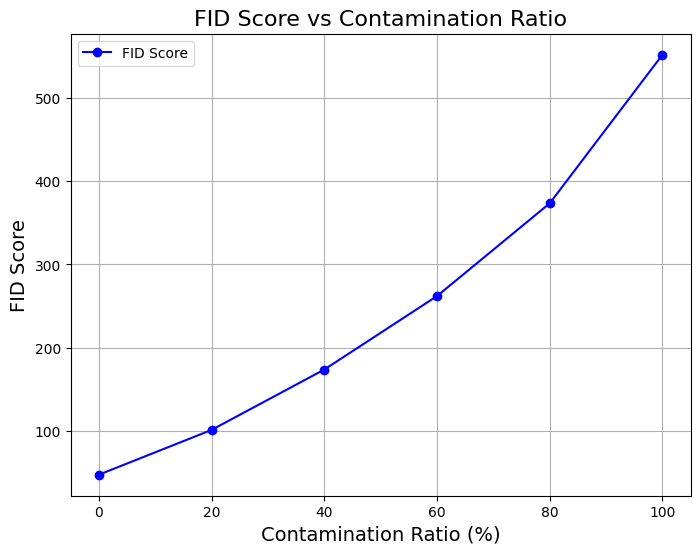

In [8]:
# Define contamination ratios
contamination_ratios = [0, 0.2, 0.4, 0.6, 0.8, 1]

# Run FID evaluation
fid_results = image_generation_with_fid(generator, contamination_ratios, num_images=1000, batch_size=32)

# Extract FID scores and contamination ratios for plotting
ratios = [result['contamination'] * 100 for result in fid_results]
fid_scores = [result['fid_score'] for result in fid_results]

# Plot FID scores vs contamination ratios
plt.figure(figsize=(8, 6))
plt.plot(ratios, fid_scores, marker='o', linestyle='-', color='b', label='FID Score')
plt.xlabel('Contamination Ratio (%)', fontsize=14)
plt.ylabel('FID Score', fontsize=14)
plt.title('FID Score vs Contamination Ratio', fontsize=16)
plt.grid(True)
plt.legend()
plt.show()
